<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 2: Epidemieausbreitung
</b></p>
<p style="font-size:25px; color: #3776ab; text-align:center">
Populationsdynamik & Netzwerke
</p>
<br>
<p style="font-size:15px; text-align:center">
von Lorenz Saalmann, Jonathan Fimmen und Peter Preisler
<br>begleitet durch Leon Sieke
</p>
<br>

# Inhaltsverzeichnis

1. Einführung
2. Verwendetes Modell
3. Grundlegende Implementation
4. Test des Grundmodells
5. Erweiterung des Modells
6. Abschließende Ergebnisse und Tests

# 1. Einführung

Das Jahr 2020 wird den meisten Menschen als das Jahr in Erinnerung bleiben, in dem die Covid-19-Pandemie den Erdball überrollt hat. Die globalisierte Welt in Verbindung mit einem passend ausgestatteten Virus haben dafür gesorgt, dass das öffentliche Leben zeitweise nahezu vollständig eingestellt werden musste um die Ausbreitung aufzuhalten. Dadurch wurde der Menschheit aufgezeigt, wie wichtig es ist die Ausbreitungsdynamik beliebiger Krankheiten zu verstehen. Denn nur dann können passende und wirksame Maßnahmen getroffen werden. Da sich unglaublich viele Faktoren auf diese Dynamik auswirken, sollten Vorbereitungen getroffen werden um möglichst gute Modelle zu erstellen. 

In dieser Arbeit werden zwei Modelle miteinander kombiniert. Die Ansteckungen werden mithilfe des SIR-Modells (Susceptible-Infected-Recovered) beschrieben, während die Reisebewegungen unter Verwendung eines Diffusionsmodells eingebracht werden. Die daraus resultierenden Differentialgleichungen werden im nächsten Kapitel diskutiert. Mit dem Modell soll anschließend die Ausbreitung einer Infektionskrankheit in Europa beschrieben werden, wobei die Flughäfen mit ihren Einzugsgebieten in der SIR-Dynamik eine Identität darstellen, welche durch das Diffusionsmodell miteiander in Verbidnung stehen.

# 2. Verwendetes Modell

2.1 SIR-Modell:

Wie der Name schon nahelegt unterscheidet das grundlegende Modell drei verschiedene Gruppen. Einmal die "Suceptible" Bevölkerung (S), welche durch die Krankheit infiziert werden kann. Dann die "Infected" Gruppe (I), welche derzeit mit der Krankheit infiziert ist. Und schließlich die "Recovered" Personen (R), welche nicht mehr von der Krankheit befallen und jetzt immun sind. Dabei wird zunächst nicht unterschieden, ob diese gestorben sind, oder sie die Krankheit besiegt haben. Es ergeben sich folgende Differntialgleichungen (wobei $N=S+I+R$ und alle zeitabhängig):

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S I}{N},\tag{1}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \beta \frac{S I}{N} -\gamma I,\tag{2}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I\tag{3}
\end{align}

Während der Parameter $\beta$ die Ansteckungsrate angibt, steht $\gamma$ in Verbindung zur Rate in der infizierte Personen versterben, oder sich von der Kranheit erholen. $\beta$ ist also abhängig davon, wie viele Menschen eine infizierte Person ansteckt, was widerrum von der Infektiösität des Virus' und der Zahl der Menschen, mit denen die Person Kontakt hat, abhängt. $\gamma$ ist hingegen durch die inverse durchschnittliche Dauer der Krankheit bestimmt.

2.2 Diffsionsmodell



In [84]:
import pandas as pd # Datenverarbeitung
import numpy as np  # Numerische Berechnungen
import matplotlib.pyplot as plt # Visualisierung
from matplotlib.animation import FuncAnimation # Animations
from IPython.display import Image # Load Animations
import cartopy.crs as ccrs # Kartenprojektionen
from scipy.integrate import solve_ivp # Numerische Lösung von Differentialgleichungen

In [85]:
# import all cleaned
airports = pd.read_csv('./datasets/cleaned_data/airports_cleaned.csv')
routes = pd.read_csv('./datasets/cleaned_data/routes_cleaned.csv')
routes_matrix = pd.read_csv('./datasets/cleaned_data/routes_matrix_cleaned.csv', index_col=0)

In [86]:
# data class to hold infection values
class City:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.S = population
        self.I = 0
        self.R = 0
    
    def infect_percent(self, percent):
        self.I += self.S * percent
        self.S = self.S - self.S * percent
        
    def infect(self, newly_infected):
        self.I += newly_infected
        self.S = self.S - newly_infected
        
    def reset_city(self):
        self.S = self.population
        self.I = 0
        self.R = 0

In [87]:
# create a dict with iata to cities
cities = {}
for airport in (airports[['population', 'IATA']]).values:
    cities[airport[1]] = (City(airport[0], airport[1]))
    
def cure_humanity():
    for c in cities.values():
        c.reset_city()    

def calculate_travel (ci : City, ds, di, dr, routes_matrix : pd.DataFrame):
    # Calculate a travel step for given city
    sumS = 0
    sumI = 0
    sumR = 0
    deg_i = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R 
        
        deg_i += 1
    
    return (ds * sumS / deg_i, di * sumI / deg_i, dr * sumR / deg_i)
      

calculate_travel(cities['AAL'], 1, 1, 1, routes_matrix)

(0.0, 0.0, 0.0)

In [88]:
def plot_SIR(title, t, s, i, r, z=[], d=[], n=[]):
    # Plot SIR values
    plt.close()
    plt.plot(t, s, label='Susceptable')
    plt.plot(t, i, c='red', label='Infected')
    plt.plot(t, r, c='green', label='Recovered')
    if (len(z) > 0):
        plt.plot(t, z, c='purple', label='Incubation')
    if (len(d) > 0):
        plt.plot(t, d, c='black',label='Dead')
    if (len(n) > 0):
        plt.plot(t, n, label='Total')
    plt.xlabel('Days')
    plt.ylabel('People')
    plt.title(title)
    plt.legend()
    plt.show()

In [89]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def calculate_SIR_ivp(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters
    def derivatives(t, state):
        S = state[0]
        I = state[1]
        
        N = c.population
        
        dS_dt = -beta / N * S * I
        dI_dt = beta / N * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]
    
    return solve_ivp(derivatives, [0, days], [c.S, c.I, c.R], max_step=1)


def calculate_SIR_runge_kutta(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters
    dt = 1
    
    t_values = np.zeros(days + 1)
    S_values = np.zeros(days + 1)
    I_values = np.zeros(days + 1)
    R_values = np.zeros(days + 1)
    
    # initial conditions
    t_values[0] = 0
    S_values[0] = c.S
    I_values[0] = c.I
    R_values[0] = c.R

    b_over_n = beta / c.population
    
    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    for i in range(days):
        t = t_values[i]
        S = S_values[i]
        I = I_values[i]
        R = R_values[i]

        # Runge Kutta to the 4th order
        k1_S, k1_I, k1_R = derivatives(S, I) * dt
        k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
        k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
        k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
        # update the solution
        t_values[i+1] = t + dt
        S_values[i+1] = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
        I_values[i+1] = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
        R_values[i+1] = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    
    return t_values, S_values, I_values, R_values

def calculate_SIR_euler(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters
    N = c.population
    time_step = 1
    t = []
    s = []
    i = []
    r = []

    for d in range(days):
        # append values to list
        t.append(d)
        s.append(c.S)
        i.append(c.I)
        r.append(c.R)
        
        # calculate each step
        dS_dt = -beta / N * c.S * c.I
        dI_dt = beta / N * c.S * c.I - gamma * c.I
        dR_dt = gamma * c.I
        
        # add steps multiplied by timestep
        c.S += dS_dt * time_step
        c.I += dI_dt * time_step
        c.R += dR_dt * time_step
    
    return t, s, i, r

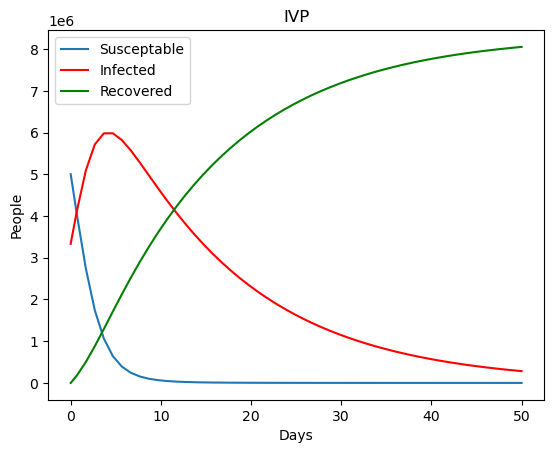

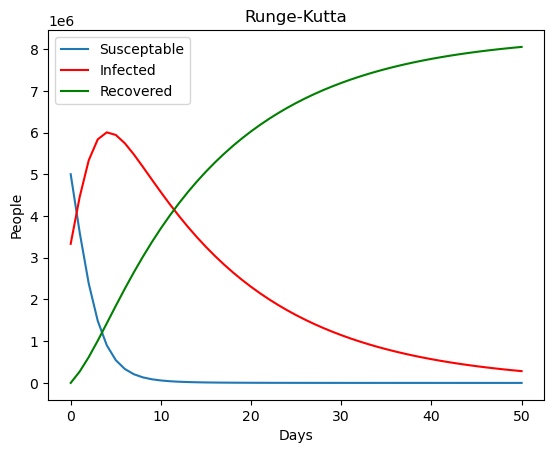

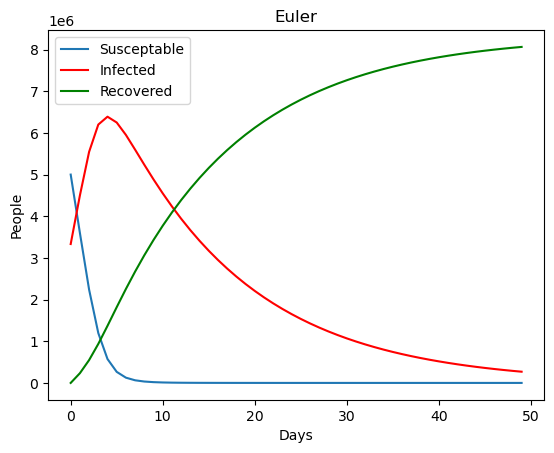

In [90]:
# infect people - intial condition
test_city = cities['LHR']
test_city.reset_city()
test_city.infect_percent(.4)

# ivp
sol = calculate_SIR_ivp(test_city, 0.7, 0.07, 50)
plot_SIR('IVP', sol.t, sol.y[0], sol.y[1], sol.y[2])

# runge-kutta
t, s, i, r = calculate_SIR_runge_kutta(test_city, 0.7, 0.07, 50)
plot_SIR('Runge-Kutta', t, s, i, r)

# euler
t, s, i, r = calculate_SIR_euler(test_city, 0.7, 0.07, 50)
plot_SIR('Euler', t, s, i, r)

In [91]:
def step_SIR(c : City, beta, gamma, dt):
    # solve the SIR differential equations within given city for given parameters

    b_over_n = beta / c.population
    
    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    S = c.S
    I = c.I
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_I, k1_R = derivatives(S, I) * dt
    k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
    k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
    k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

In [92]:
def combined_simulation(beta, gamma, ds, di, dr, days):
    
    SIR_values = {}
    for c in cities:
        SIR_values[c] = []
    t = [0]

    # add initial state
    for c in cities.values():
        SIR_values[c.IATA].append((c.S, c.I, c.R))
        
    for i in range(days):
        for c in cities.values():
            c = step_SIR(c,beta,gamma,1)
            diff_S, diff_I, diff_R = calculate_travel (c, ds, di, dr, routes_matrix)
            c.S += diff_S
            c.I += diff_I
            c.R += diff_R
            
            SIR_values[c.IATA].append((c.S, c.I, c.R))
            
        t.append(i+1)    
    return t, SIR_values

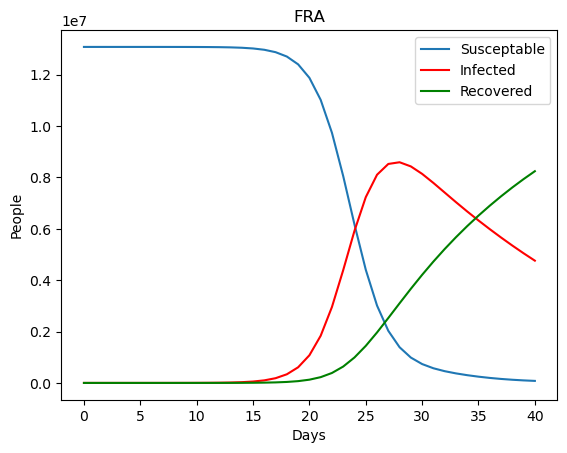

In [93]:
cure_humanity()
cities['FRA'].infect(5)
t, SIR_values = combined_simulation(0.7,0.07,0.01,0.01,0.01,40)
stadt='FRA'
S, I, R = zip(*SIR_values[stadt])

plot_SIR(stadt, t, S, I, R)

In [94]:
connection_lines = {}
city_markers = []

def initialize_plot ():
    # Create a new map with the PlateCarree projection.
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    # Create a mapping from airport IATA codes to latitudes and longitudes
    airport_IATA_to_lat_lon = {row[0] : {'lat': row[1], 'lon': row[2]} for row in airports[['IATA', 'latitude', 'longitude']].values}

    # create markers and lines
    for i, city in enumerate(cities):
        pos = airport_IATA_to_lat_lon[city]
        marker = ax.plot(pos['lon'], pos['lat'], 'o', transform=ccrs.Geodetic(), c='blue', markersize = 2)
        city_markers.append(marker[0])
        
        connection_lines[i] = []
        for j in range(i):
            if routes_matrix.iloc[i, j] != 0:
                source_pos = pos
                dest_pos = airport_IATA_to_lat_lon[routes_matrix.columns[j]]
                line = ax.plot([source_pos['lon'], dest_pos['lon']],[source_pos['lat'], dest_pos['lat']],transform=ccrs.Geodetic(), c='r', alpha=0, markersize=.02)
                connection_lines[i].append((j, line[0]))
    
    
    global initialized
    initialized = True
    return ax

def plot_state(ax, SIR, day, show_routes=False):
    
    for i, city in enumerate(SIR):
        S, I, R = SIR[city][day]
        N = (S + I + R)
        infection_percent = I / N
        # update markers
        marker = city_markers[i]
        marker.set_color((I/N, R/N, S/N))
        marker.set_markersize(2 + 2 * infection_percent)

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Ij, Rj = SIR[list(SIR.keys())[j]][day]
            Nj = Sj + Ij+ Rj
            line.set(alpha = abs((N/Nj * Ij - I)) / (N) * 0.1)

In [95]:
initialized = False

def create_infection_progress_animation(SIR_values, days, title, show_routes=False):
    fig = plt.figure(figsize=(16, 9))
    if (not initialized):
        ax = initialize_plot()
    
    def update(frame):
        print(frame)
        ax.set_title(f'{title} - Day {frame}')
        plot_state(ax, SIR_values, frame, show_routes=show_routes)

    animation = FuncAnimation(fig, update, frames=days, interval=200)
    
    plt.close()
    # save animation
    animation.save("figures/infection.gif", fps=2)
   
    Image(url='figures/infection.gif')

# 5 Erweitertung des Modells



\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S (I + A)}{N} + \lambda R,\tag{4}\\
    &\frac{\mathrm{d} Z}{\mathrm{d} t} = \beta \frac{S (I + A)}{N} - \kappa Z,\tag{5}\\
    &\frac{\mathrm{d} A}{\mathrm{d} t} = (1-\sigma)\kappa Z - \upsilon A,\tag{6} \\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \sigma \kappa Z - \gamma I,\tag{7}\\
    &\frac{\mathrm{d} D}{\mathrm{d} t} = \mu (\upsilon A + \gamma I),\tag{8}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = (1-\mu)(\upsilon A+\gamma I)\tag{9}
\end{align}

In [96]:
# data class to hold infection values
class ExpCity:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.S = population
        self.Z = 0
        self.I = 0
        self.D = 0
        self.R = 0
    
    def infect_percent(self, percent):
        self.Z += self.S * percent
        self.S = self.S - self.S * percent
        
    def infect(self, newly_infected):
        self.Z += newly_infected
        self.S = self.S - newly_infected
        
    def reset_city(self):
        self.S = self.population
        self.Z = 0
        self.I = 0
        self.D = 0
        self.R = 0

In [97]:
# create a new dict with iata to cities
cities = {}
for airport in (airports[['population', 'IATA']]).values:
    cities[airport[1]] = (ExpCity(airport[0], airport[1]))

In [98]:
def step_SZIDR(c : ExpCity, beta, gamma, _lambda, kappa, mu, dt):
    # SIR + incubation + recovered -> susceptable

    b_over_n = beta / c.population
    
    def derivatives(S, Z, I, R):
        dS_dt = -b_over_n * S * I + _lambda * R
        dZ_dt = b_over_n * S * I - kappa * Z
        dI_dt = - gamma * I + kappa * Z
        dD_dt = mu * gamma * I
        dR_dt = (1-mu) * gamma * I - _lambda * R

        return dS_dt, dZ_dt, dI_dt, dD_dt, dR_dt
    
    S = c.S
    Z = c.Z
    I = c.I
    D = c.D
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_Z, k1_I, k1_D, k1_R = derivatives(S, Z, I, R) * dt
    k2_S, k2_Z, k2_I, k2_D, k2_R = derivatives(S + 0.5 * k1_S, Z + 0.5 * k1_Z, I + 0.5 * k1_I, R + 0.5 * k1_R) * dt
    k3_S, k3_Z, k3_I, k3_D, k3_R = derivatives(S + 0.5 * k2_S, Z + 0.5 * k2_Z, I + 0.5 * k2_I, R + 0.5 * k2_R) * dt
    k4_S, k4_Z, k4_I, k4_D, k4_R = derivatives(S + k3_S, Z + k3_Z, I + k3_I, R + k3_R) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.Z = Z + (1/6) * (k1_Z + 2*k2_Z + 2*k3_Z + k4_Z)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.D = D + (1/6) * (k1_D + 2*k2_D + 2*k3_D + k4_D)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

146517.69333380027


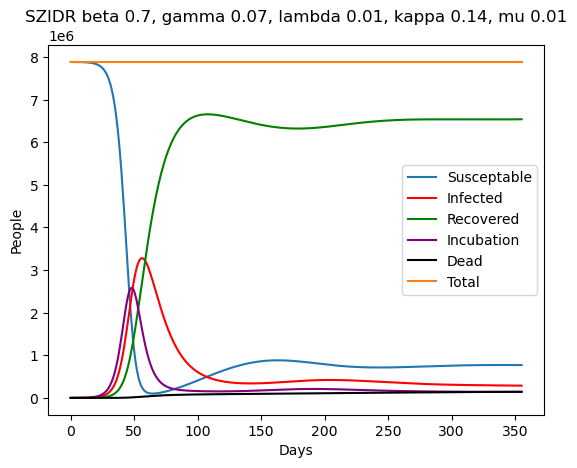

In [99]:
# infect people - intial condition
test_city = cities['MUC']
test_city.reset_city()
test_city.infect(1000)

beta = 0.7
gamma = 0.07
lambda_0 = 1/90
kappa = 1/7
mu = .01

t,s,z,i,d,r = ([] for i in range(6))
total_i= 0
total = []
for n in range(356 * 1):
    t.append(n)
    s.append(test_city.S)
    z.append(test_city.Z)
    i.append(test_city.I)
    d.append(test_city.D)
    r.append(test_city.R)
    total.append(test_city.S + test_city.Z + test_city.I + test_city.D + test_city.R)

    total_i += kappa * test_city.Z

    test_city = step_SZIDR(test_city, beta, gamma, lambda_0 * (0.5 ** (total_i / test_city.population)), kappa, mu, 1)


print(d[-1])
plot_SIR(f"SZIDR beta {beta}, gamma {round(gamma, 2)}, lambda {round(lambda_0,2)}, kappa {round(kappa,2)}, mu {mu}", t, s, i, r, z, d, total)

In [100]:
def calculate_travel_exp (ci : City, ds, dz, di, dr, routes_matrix : pd.DataFrame):
    # Calculate a travel step for given city
    sumS = 0
    sumZ = 0
    sumI = 0
    sumR = 0

    deg_i = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumZ += n * cj.Z - ci.Z
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R 
        
        deg_i += 1
    
    return (ds * sumS / deg_i, dz * sumZ / deg_i, di * sumI / deg_i, dr * sumR / deg_i)

In [101]:
def combined_simulation_exp (beta, gamma, lambda_0, kappa, mu, ds, dz, di, dr, days):
    
    SZIDR_values = {}
    for c in cities:
        SZIDR_values[c] = []
    t = [0]

    # add initial state
    for c in cities.values():
        SZIDR_values[c.IATA].append((c.S, c.Z, c.I, c.D, c.R))
        
    for i in range(days):
        for c in cities.values():
            c = step_SZIDR(c, beta, gamma,lambda_0, kappa, mu, 1)
            diff_S, diff_Z, diff_I, diff_R = calculate_travel_exp (c, ds, dz, di, dr, routes_matrix)
            c.S += diff_S
            c.Z += diff_Z
            c.I += diff_I
            c.R += diff_R
            
            SZIDR_values[c.IATA].append((c.S, c.Z, c.I, c.D, c.R))
            
        t.append(i+1)    
    return t, SZIDR_values

In [111]:
def plot_state_exp(ax, SZIDR, day, show_routes=False):
    
    for i, city in enumerate(SZIDR):
        S, Z, I, D, R = SZIDR[city][day]
        N = (S + Z +I + D + R)
        infection_percent = I / N
        # update markers
        marker = ax.get_lines()[i]
        color = (I/N, R/N, S/N)
        brightness = 1 - D/N
    
        marker.set(color = tuple([c* brightness for c in color]))
        marker.set_markersize(2 + 2 * (infection_percent + D/N))

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Zj, Ij, Dj, Rj = SZIDR[list(SZIDR.keys())[j]][day]
            Nj = Sj + Zj + Ij+ Dj + Rj
            line.set(alpha = abs((N/Nj * Ij - I)) / (N) * 0.1)
        
            

In [112]:
ax = None
def create_infection_progress_animation_exp(SZIDR_values, days, title, show_routes=False):
    fig = plt.figure(figsize=(16, 9))
    global ax
    
    ax = initialize_plot()
    
    def update_exp(frame):
        print(frame)
        ax.set_title(f'{title} - Day {frame}')
        plot_state_exp(ax, SZIDR_values, frame, show_routes=show_routes)
        return ax

    animation = FuncAnimation(fig, update_exp, frames=days, interval=200)
    
    plt.close()
    # save animation
    animation.save("figures/infection.gif", fps=2)
   
    Image(url='figures/infection.gif')

In [113]:
cure_humanity()
city = cities['LIS']
city.infect_percent(.1)
days = 90
t, SZIDR_values = combined_simulation_exp(0.8, 0.07, 1/90, 1/5, .8, 0.01, 0.01, 0.01, 0.01, days)
#S, Z, I, D, R = zip(*SZIDR_values[city.IATA])

#plot_SIR("Test", t, S, I, R, Z, D)

create_infection_progress_animation_exp(SZIDR_values, days, "SZIDR", True)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
